# Imports & Env. Config

In [1]:
!pip install mmcif_pdbx
!pip install pandas-profiling
!pip install pyarrow
!pip install biopython
!chmod 777 -R blast/

# mmCIF / Protein Libs
import pdbx
from pdbx.reader import PdbxReader
from pdbx.reader import DataContainer
from Bio.Blast.Applications import NcbiblastpCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio import SearchIO

# I/O Libs
from google.cloud import storage
import io
from io import StringIO
import os
from IPython.display import clear_output
from google.cloud.storage import Blob

# Data Manipulation Libs
import pandas as pd
import numpy as np
import math
import random
import gzip
import pyarrow as pa
import pyarrow.parquet as pq

# Viz Libs
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns; sns.set()

# ML Libs
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.cluster import OPTICS
from sklearn.datasets import make_blobs

os.environ['PATH'] = '/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/pss/blast/bin/:'

clear_output()

In [2]:
# Instantiates a client & loads credentials
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "PSS GCS Storage Key.json"
storage_client = storage.Client()

# Download List of Filenames (mmCIF) From GCS

In [3]:
path = 'UP000005640_9606_HUMAN/cif/'
filenames = []
blob_list = storage_client.get_bucket('capstone-fall21-protein').list_blobs()
for blob in blob_list:
    if path in blob.name:
        filenames.append(blob.name[27:].split('.')[0])
print(f'Indexed {len(filenames)} files.')

Indexed 23391 files.


# Set Randomization & Plotting Options

In [170]:
random_seed = 76523
random.seed(random_seed)
color_map = 'inferno'

# Control: BLAST Scores + e-Values for Randomly Clustered Proteins

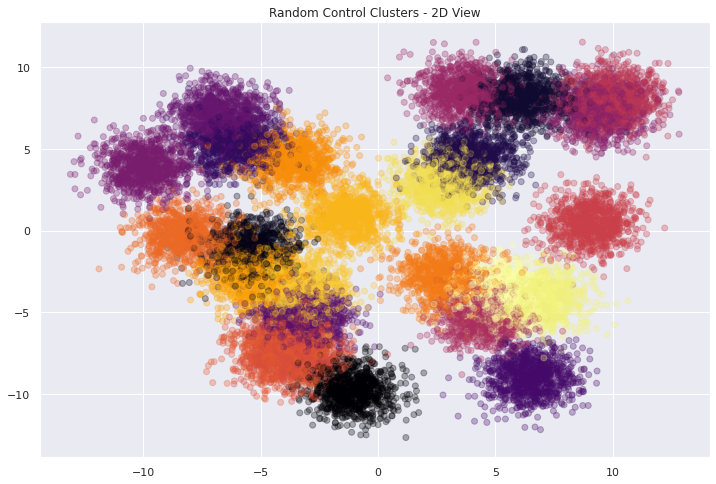

In [171]:
# create random 3D clusters of len(filenames)
X, y = make_blobs(n_samples=len(filenames), centers=25, n_features=3, random_state=random_seed)

# 2D visualization
figure(figsize=(12,8))
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.3, cmap=color_map)
plt.title('Random Control Clusters - 2D View')
plt.show()

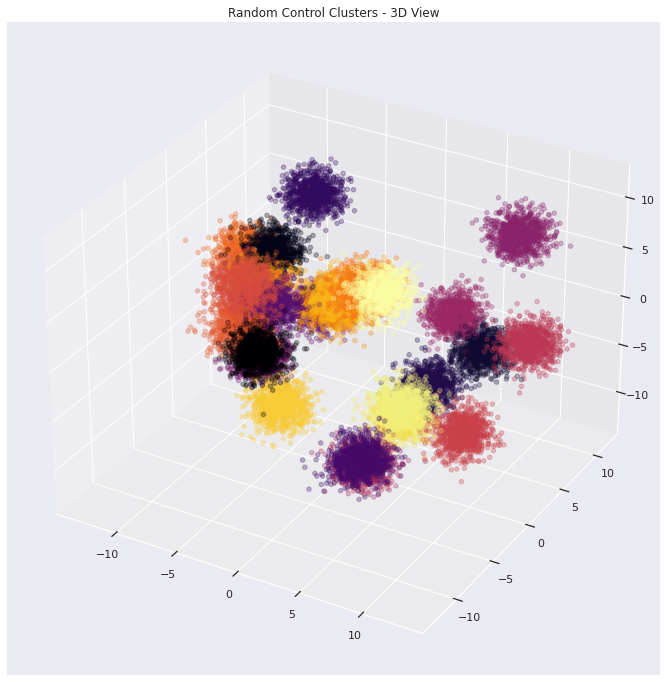

In [172]:
# 3D visualization
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, alpha=0.3, cmap=color_map)
ax.figure.set_size_inches((12,12))
ax.set_title('Random Control Clusters - 3D View')
plt.show()

In [77]:
# WARNING: Re-running this as-is will result in the same random control data being overwritten
#          in GCS. That's OK. HOWEVER, if you changed the random_seed value, you WILL OVERWRITE
#          OUR CANONICAL CONTROL DATA in GCS. This is annoying because you may now have to re-run
#          the BLAST reports for new combinations of proteins we didn't see under the original
#          random seed. Also it'll make comparing model performance across our embeddings very
#          confusing.

# Append cluster labels and random proteins to X; sort by cluster label
random.seed(random_seed)
shuffled_filenames = filenames.copy()
random.shuffle(shuffled_filenames)
control_data = np.append(X, y.reshape((len(y),1)), axis=1)
control_data = np.append(control_data, np.array(shuffled_filenames).reshape(len(filenames), 1), axis=1)
control_data = control_data[np.argsort(control_data[:, 3])]

# Save to local and GCS
pd.DataFrame(control_data, columns=['X', 'Y', 'Z', 'cluster_label', 'protein']).to_csv('random_control_clusters.csv', index=False)
bucket = storage_client.get_bucket('capstone-fall21-protein')
blob = Blob("clusters/random_control_clusters.csv", bucket)
with open('random_control_clusters.csv', "rb") as my_file:
     blob.upload_from_file(my_file)
print(f'Random control cluster data saved to GCS.')

Random control cluster data saved to GCS.


## Helper Functions to Run BLAST & Process / Upload Data

In [47]:
def get_protein_sequence(selection=None, local=False):
    '''
    Given a list of proteins (full filenames), returns atoms' X, Y and Z coordinates
    along with protein name. If no selection is provided, returns all proteins' (23K)
    atoms.
    '''
    stats = [0, 0]
    result = []
    alias = 'tmp.cif.gz'
    dl_path = 'local_cifs/'
    
    if selection is None:
        selection = filenames

    for file in selection:
        data=[]
        # load from remote if local=True, else from local
        if local is False:
            
            blob = storage_client.get_bucket('capstone-fall21-protein').get_blob(path + file + '.cif.gz')
            blob.download_to_filename(alias)

            with gzip.open(alias) as f:
                file_content = f.read()
                
            txt = io.StringIO(file_content.decode("utf-8"))
        else:
            with open(dl_path + file + '.cif', 'r') as f:
                file_content = f.read()
            txt = io.StringIO(file_content)
        
        stats[0] += 1
        pRd = PdbxReader(txt)
        pRd.read(data)
        block = data[0]
        obj = block.get_object("struct_ref")

        for row in obj.get()[2]:
            result.append(row)

        stats[1] += len(obj.get()[2])
        if local is False:
            txt.close()
            os.remove(alias)

    #print(f'Processed {stats[0]} proteins ({stats[1]} rows).')
    result = np.array(result)
    result = np.append(np.array(selection).reshape((len(result),1)), result[:,7].reshape((len(result),1)), axis=1) #result[:,5].reshape((len(result),1))
    clear_output()
    return result

In [52]:
def sequences_to_fasta(sequences, filename='tmp.fasta'):
    f = open(filename, "w")

    for protein, sequence in sequences:
        sequence = sequence.replace('\n', '')
        f.write(f'>{protein}')

        for pos in range(len(sequence)):
            if pos % 60 == 0:
                f.write('\n')
            f.write(sequence[pos])

        f.write('\n')

    f.close()
    #print(f'{len(sequences)} Protein sequences concatenated into tmp.fasta.')

In [57]:
def process_report(filename='results.out'):
    parser = SearchIO.parse(filename, "blast-tab")
    num_queries = len(list(parser))
    parser = SearchIO.parse(filename, "blast-tab")

    formatted_data = []

    for queries in range(num_queries):
        result = next(parser)
        for hsp in result.hsps:
            # ignore self-matches
            if result.id != hsp.hit_id:
                formatted_data.append([result.id, hsp.hit_id, hsp.bitscore, hsp.evalue])

    return formatted_data


def append_annotations(new_annotations):
    if not os.path.exists('blast_annotations.csv'):
        pd.DataFrame(None, columns=['query_protein', 'target_protein', 'bitscore', 'evalue']).to_csv('blast_annotations.csv', index=False)
    
    pd.DataFrame(new_annotations, columns=['query_protein', 'target_protein', 'bitscore', 'evalue']).to_csv('blast_annotations.csv', index=False, mode='a', header=False)
    bucket = storage_client.get_bucket('capstone-fall21-protein')
    blob = Blob("annotations/blast_annotations.csv", bucket)
    with open('blast_annotations.csv', "rb") as my_file:
         blob.upload_from_file(my_file)

def get_gcs_annotations():
    bucket = storage_client.get_bucket('capstone-fall21-protein')
    blob = Blob("annotations/blast_annotations.csv", bucket)
    blob.download_to_filename('blast_annotations.csv')

In [33]:
def download_cifs():
    dl_path = 'local_cifs/'
    total = len(filenames)
    i = 0

    for file in filenames:
        i += 1
        print(f'{i} of {total}')
        data=[]
        blob = storage_client.get_bucket('capstone-fall21-protein').get_blob(path + file + '.cif.gz')
        blob.download_to_filename(file + '.cif.gz')
        with gzip.open(file + '.cif.gz') as f:
            file_content = f.read()
        f = open(dl_path + file + '.cif', "w")
        f.write(file_content.decode("utf-8"))
        f.close()
        os.remove(file + '.cif.gz')
        clear_output()

## Run BLAST on Remote Data + Upload on Control Random Clusters

In [123]:
# Iterate through each cluster and BLAST member proteins.
# Write entire space's BLAST scores to GCS annotations folder

# WARNING: BE VERY CAREFUL BEFORE RUNNING THIS. If you do not have the latest full annotations
#          file from GCS, this code will create a new blank on locally, append your session's
#          BLAST results, and then OVERWRITE the current full annotations file in GCS.
#          If in doubt, run get_gcs_annotations() first to pull the latest one from GCS, and
#          then run your code to APPEND to it.

# get_gcs_annotations()

for cluster_label in np.unique(control_data[:,3]):
    cluster_proteins = control_data[control_data[:,3] == cluster_label][:,4]
    cluster_sequences = get_protein_sequence(cluster_proteins)
    sequences_to_fasta(cluster_sequences)
    
    !./blast/bin/makeblastdb -in tmp.fasta -parse_seqids -blastdb_version 5 -dbtype prot
    !./blast/bin/blastp -db tmp.fasta -query tmp.fasta -out results.out -outfmt 6
    
    append_annotations(process_report())
    clear_output()

## Run BLAST on Full 23K Dataset (Only Local)

In [58]:
# Uncomment next line only if you need to download all mmCIFs again
#download_cifs()
z = get_protein_sequence(filenames, local=True)
sequences_to_fasta(z, 'tmp_full.fasta')

!./blast/bin/makeblastdb -in tmp_full.fasta -parse_seqids -blastdb_version 5 -dbtype prot
!./blast/bin/blastp -db tmp_full.fasta -query tmp_full.fasta -out results_full.out -outfmt 6
    
k = process_report('results_full.out')
append_annotations(k)



Building a new DB, current time: 09/28/2021 05:52:41
New DB name:   /home/jupyter/pss/tmp_full.fasta
New DB title:  tmp_full.fasta
Sequence type: Protein
Deleted existing Protein BLAST database named /home/jupyter/pss/tmp_full.fasta
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 5 sequences in 0.000721931 seconds.




[['AF-A0A024R1R8-F1-model_v1', 'AF-A0A024RBG1-F1-model_v1', 12.7, 3.7],
 ['AF-A0A024RCN7-F1-model_v1', 'AF-A0A024RBG1-F1-model_v1', 13.5, 3.1],
 ['AF-A0A024RCN7-F1-model_v1', 'AF-A0A024RBG1-F1-model_v1', 12.3, 6.5],
 ['AF-A0A024RCN7-F1-model_v1', 'AF-A0A075B6H7-F1-model_v1', 12.7, 5.6],
 ['AF-A0A075B6H5-F1-model_v1', 'AF-A0A075B6H7-F1-model_v1', 30.0, 9.22e-06],
 ['AF-A0A075B6H5-F1-model_v1', 'AF-A0A024RCN7-F1-model_v1', 14.6, 1.7],
 ['AF-A0A075B6H7-F1-model_v1', 'AF-A0A075B6H5-F1-model_v1', 26.9, 9.17e-05],
 ['AF-A0A075B6H7-F1-model_v1', 'AF-A0A024RCN7-F1-model_v1', 17.7, 0.13]]

**Plots for First Class Presentation**

In [127]:
m = pd.read_csv('blast_annotations.csv').sort_values(['bitscore', 'evalue'], ascending=[False, True])

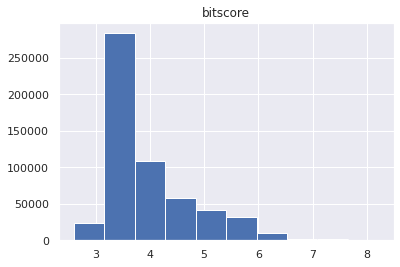

In [130]:
m[['bitscore']].apply(np.log).hist();

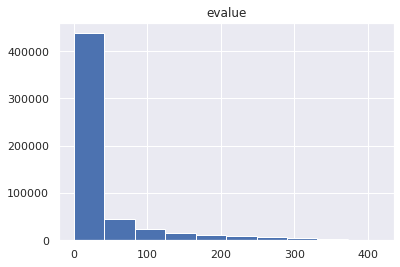

In [131]:
m[['evalue']][m.evalue > 0].apply(np.log).apply(np.abs).hist();

**Re-Implementation TODOs:**
* Wrap BLAST pipeline in function
* First check if input pairs have already been BLASTed in annotations csv
* If so, return pre-computed scores
* If not, run BLAST pipeline, append to annotations csv
* Return results

In [134]:
control = pd.read_csv('random_control_clusters.csv')
control.head()

,X,Y,Z,cluster_label,protein
0,0.301233,-8.562800,4.578280,0.0,AF-Q8NGM8-F1-model_v1
1,-0.696560,-9.549314,3.310651,0.0,AF-Q16890-F1-model_v1
2,-1.209301,-9.101894,5.489452,0.0,AF-Q92567-F1-model_v1
3,-1.347963,-10.670640,5.729466,0.0,AF-Q02083-F1-model_v1
4,-0.250609,-11.641344,3.574381,0.0,AF-P61421-F1-model_v1


In [145]:
import itertools

a = control.protein.to_list()
b = control.protein.to_list()
c = list(itertools.product(a, b))
c[0]

KeyboardInterrupt: 

**Test BLAST Parameters on Small Query (Target)**

In [263]:
# -outfmt 6 means tab-delimited; corresponding param for SearchIO.parse is "blast-tab"
!./blast/bin/blastp -db tmp.fasta -query tmp_test.fasta -out results_test.out -outfmt 6

In [264]:
parser = SearchIO.parse("results_test.out", "blast-tab")
num_queries = len(list(parser))
parser = SearchIO.parse("results_test.out", "blast-tab")

formatted_data = []

for queries in range(num_queries):
    result = next(parser)
    for hsp in result.hsps:
        formatted_data.append([result.id, hsp.hit_id, hsp.bitscore, hsp.evalue])

In [265]:
pd.DataFrame(formatted_data, columns=['query_protein', 'target_protein', 'bitscore', 'evalue']).to_csv('blast_annotations_test.csv', index=False)
bucket = storage_client.get_bucket('capstone-fall21-protein')
my_file.upload_from_file(open('blast_annotations_test.csv'))

# Scratch

## BLAST Example

In [107]:
# First download and unpack BLAST+ (linux x86) at /home/jupyter/pss/blast/
# Make sure /home/jupyter/pss/blast/bin/* has been chmod 777'd

# Create two sequence files
seq1 = SeqRecord(Seq(cluster_1_sequences[0][1]), id=cluster_1_sequences[0][0])
seq2 = SeqRecord(Seq(cluster_1_sequences[1][1]), id=cluster_1_sequences[1][0])
SeqIO.write(seq1, "seq1.fasta", "fasta")
SeqIO.write(seq2, "seq2.fasta", "fasta")

# Run BLAST and parse the output as XML
output = NcbiblastpCommandline(query="seq1.fasta", subject="seq2.fasta", outfmt=5)()[0]
blast_result_record = NCBIXML.read(StringIO(output))

# The BLAST E-value is the number of expected hits of similar quality (score)
# that could be found just by chance. E-value of 10 means that up to 10 hits can
# be expected to be found just by chance, given the same size of a random
# database. The lower the E-value, or the closer it is to zero, the more 
# "significant" the match is.

# The bit score, S', is derived from the raw alignment score, S, taking the
# statistical properties of the scoring system into account. Because bit scores 
# are normalized with respect to the scoring system, they can be used to compare
# alignment scores from different searches. Higher is better, but after 50 there
# is little added statistical benefit.

for alignment in blast_result_record.alignments:
    for hsp in alignment.hsps:
        print('****Alignment****')
        print('sequence:', alignment.title)
        print('length:', alignment.length)
        print('e value:', hsp.expect)
        print('score:', hsp.score)
        #print(hsp.query)
        #print(hsp.match)
        #print(hsp.sbjct)

****Alignment****
sequence: A0A024RBG1 A0A024RBG1 <unknown description>
length: 181
e value: 1.19342
score: 21.0


## Atom Cartesian Coordinate Clustering (see [`protein_eda`](protein_eda.ipynb) Notebook)

In [89]:
X = atoms[['_atom_site.Cartn_x', '_atom_site.Cartn_y', '_atom_site.Cartn_z']].copy(deep=True)
X.to_numpy()
X = preprocessing.StandardScaler().fit(X).transform(X)

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
y_kmeans = kmeans.predict(X)

figure(figsize=(14,10))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=5, cmap='summer', alpha=0.3)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

## How to Write Parquet Files

In [177]:
table = pa.Table.from_pandas(pd.DataFrame(r[:5]))
pq.write_table(table, 'repr_random.parquet')

## Proof of Concept for Randomly Sampling Proteins, Unzipping & Processing

In [ ]:
data=[]
stats = [0, 0]
result = []
alias = 'tmp.cif.gz'

for file in random.sample(filenames, 10):
    blob = storage_client.get_bucket('capstone-fall21-protein').get_blob(file)
    blob.download_to_filename(alias)

    with gzip.open(alias) as f:
        file_content = f.read()

    txt = io.StringIO(file_content.decode("utf-8"))

    stats[0] += 1
    pRd = PdbxReader(txt)
    pRd.read(data)
    txt.close()
    block = data[0]

    obj = block.get_object("atom_site")

    for row in obj.get()[2]:
        result.append(row)

    stats[1] += len(obj.get()[2])

os.remove(alias)
print(f'Processed {stats[0]} proteins ({stats[1]} rows).')

In [ ]:
atoms = pd.DataFrame(data=result, columns=obj.item_name_list, dtype=float)
atoms.sample(10)

## Get Atoms

In [6]:
def get_atoms(selection=None):
    '''
    Given a list of proteins (full filenames), returns atoms' X, Y and Z coordinates
    along with protein name. If no selection is provided, returns all proteins' (23K)
    atoms.
    '''
    stats = [0, 0]
    result = []
    alias = 'tmp.cif.gz'
    
    if selection is None:
        selection = filenames
    
    for file in selection:
        data = []
        blob = storage_client.get_bucket('capstone-fall21-protein').get_blob(file)
        blob.download_to_filename(alias)

        with gzip.open(alias) as f:
            file_content = f.read()

        txt = io.StringIO(file_content.decode("utf-8"))

        stats[0] += 1
        pRd = PdbxReader(txt)
        pRd.read(data)
        txt.close()

        block = data[0]
        obj = block.get_object("atom_site")

        for row in obj.get()[2]:
            result.append(row)

        stats[1] += len(obj.get()[2])
        os.remove(alias)
    
    print(f'Processed {stats[0]} proteins ({stats[1]} rows).')
    result = np.array(result)
    result = np.column_stack((result[:,10:13], result[:,21]))
    return result

In [ ]:
cluster_1_atoms = get_atoms(cluster_1_examples['protein'].to_list())
pd.DataFrame(cluster_1_atoms, columns=['X', 'Y', 'Z', 'protein'])

## Misc.

In [ ]:
# NOT USED CURRENTLY
# extract protein names from filenames and generate 500 len random vector for each

#r = []
#for f in filenames:
#    r.append([f[30:].split("-", 1)[0], [random.random() for n in range(500)]])
#r = np.array(r)
#X = np.stack(r[:,1], axis=0)